### start -- load MNIST data (used for all experiments)

In [1]:
from keras.datasets import mnist
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    print(x_train.shape)
    print(x_test.shape)
    return x_train, x_test, y_train, y_test

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
def load_mnist_data_as_2d_images():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
    print(x_train.shape)
    print(x_test.shape)
    return x_train, x_test, y_train, y_test

## simplest AE using 1 FC layer for encoder and decoder

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import numpy as np

Using TensorFlow backend.


In [2]:
#AE_fc.py

class DenseAE(object):
    def __init__(self, input_dims=784, dense_layers=1, add_sparsity_constraint=None):
        self.input_dims= input_dims
        # this is our input placeholder
        self.input_img = Input(shape=(input_dims,))
        self.dense_nb_layers = dense_layers
        # The representations is only constrained by the size of the hidden layer (32). In such a situation,
        # what typically happens is that the hidden layer is learning an approximation of PCA
        # (principal component analysis).
        self.encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
        self.add_sparsity_constraint=add_sparsity_constraint
        if not add_sparsity_constraint:
            self.setup_training_model()
        else:
            self.setup_sparse_training_model(add_sparsity_constraint)

    def setup_training_model(self):
        # "encoded" is the encoded representation of the input        
        self.encoded = Dense(self.encoding_dim, activation='relu')(self.input_img)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = Dense(self.input_dims, activation='sigmoid')(self.encoded)

        # this model maps an input to its reconstruction
        self.autoencoder = Model(self.input_img, self.decoded)

#     def __init__(self, input_dims=784, encoding_dim=[32], add_sparsity_constraint=None):
#         self.input_dims= input_dims
#         # this is our input placeholder
#         self.input_img = Input(shape=(input_dims,))
#         # The representations is only constrained by the size of the hidden layer (32). In such a situation,
#         # what typically happens is that the hidden layer is learning an approximation of PCA
#         # (principal component analysis).
#         self.encoding_dim = encoding_dim  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
#         self.add_sparsity_constraint=add_sparsity_constraint
#         if not add_sparsity_constraint:
#             self.setup_training_model()
#         else:
#             self.setup_sparse_training_model()

#     def setup_training_model(self):
#         for index,fc_dim in enumerate(self.encoding_dim):
#             print(index,fc_dim)
#             if index == 0:
#                 encoded = Dense(fc_dim, activation='relu')(self.input_img)
#             else:
#                 encoded = Dense(fc_dim, activation='relu')(encoded)
#         self.encoded = encoded
        
#         for index,fc_dim in enumerate(self.encoding_dim):
#             print(index,fc_dim)
#             if index == 0:
#                 decoded = Dense(fc_dim, activation='sigmoid')(self.encoded)
#             else:
#                 decoded = Dense(fc_dim, activation='sigmoid')(decoded)        
#         self.decoded = decoded
        
#         # this model maps an input to its reconstruction
#         self.autoencoder = Model(self.input_img, self.decoded)        

    def setup_sparse_training_model(self, add_sparsity_constraint='L1'):
        if add_sparsity_constraint == 'L1':
            # add a Dense layer with a L1 activity regularizer
            self.encoded = Dense(self.encoding_dim, activation='relu',
                             activity_regularizer=regularizers.l1(10e-5))(self.input_img)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = Dense(self.input_dims, activation='sigmoid')(self.encoded)
        # this model maps an input to its reconstruction
        self.autoencoder_sparse = Model(self.input_img, self.decoded)
        
    def encoder_model(self):
        # this model maps an input to its encoded representation
        return Model(self.input_img, self.encoded)

    def decoder_model(self):
        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(self.encoding_dim,))
        # retrieve the last layer of the autoencoder model
        decoder_layer = self.autoencoder.layers[-1]
        # create the decoder model
        return Model(encoded_input, decoder_layer(encoded_input))

    def train(self, x_train, x_val, nb_epochs=50):
        if self.add_sparsity_constraint:
            self.autoencoder = self.autoencoder_sparse
        self.autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.autoencoder.fit(x_train, x_train,
                        epochs=nb_epochs,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_val, x_val))

In [4]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

def plot_decoded_results(x_val, decoded_imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_val[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [6]:
x_tr, x_val = load_mnist_data()
fc1AE = DenseAE(input_dims=784)
fc1AE.train(x_tr, x_val, nb_epochs=40)
print("Training AE done")

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 76us/step - loss: 0.3752 - val_loss: 0.2725
Epoch 2/40
60000/60000 [==============================] - 5s 76us/step - loss: 0.2646 - val_loss: 0.2536
Epoch 3/40
60000/60000 [==============================] - 4s 68us/step - loss: 0.2424 - val_loss: 0.2295
Epoch 4/40
60000/60000 [==============================] - 3s 58us/step - loss: 0.2212 - val_loss: 0.2115
Epoch 5/40
60000/60000 [==============================] - 4s 62us/step - loss: 0.2068 - val_loss: 0.1998
Epoch 6/40
60000/60000 [==============================] - 3s 56us/step - loss: 0.1967 - val_loss: 0.1908
Epoch 7/40
60000/60000 [==============================] - 3s 55us/step - loss: 0.1885 - val_loss: 0.1832
Epoch 8/40
60000/60000 [==============================] - 4s 59us/step - loss: 0.1815 - val_loss: 0.1769
Epoch 9/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.1755 - val_loss: 0.1712
Epoch

In [7]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = fc1AE.encoder_model().predict(x_val)
decoded_imgs = fc1AE.decoder_model().predict(encoded_imgs)

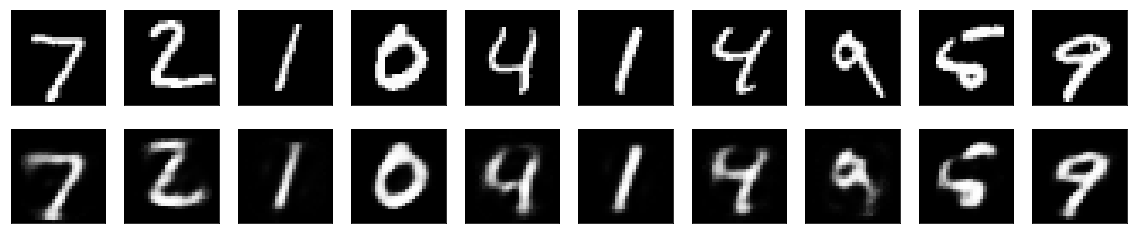

mean encoded activations fc1 6.94059


In [8]:
plot_decoded_results(x_val, decoded_imgs)
print("mean encoded activations fc1" ,encoded_imgs.mean())

### sparse model with L1 regu

In [9]:
x_tr, x_val = load_mnist_data()
fc1AE_sparse = DenseAE(input_dims=784,dense_layers=1,add_sparsity_constraint='L1')
fc1AE_sparse.train(x_tr, x_val, nb_epochs=100)
print("Training AE with L1 constraint done")

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 68us/step - loss: 0.6829 - val_loss: 0.6606
Epoch 2/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.6440 - val_loss: 0.6272
Epoch 3/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.6111 - val_loss: 0.5952
Epoch 4/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.5802 - val_loss: 0.5655
Epoch 5/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.5518 - val_loss: 0.5386
Epoch 6/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.5263 - val_loss: 0.5145
Epoch 7/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.5036 - val_loss: 0.4932
Epoch 8/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.4835 - val_loss: 0.4743
Epoch 9/100
60000/60000 [==============================] - 4s 68us/step - loss: 0.4658 - val_loss: 0.4

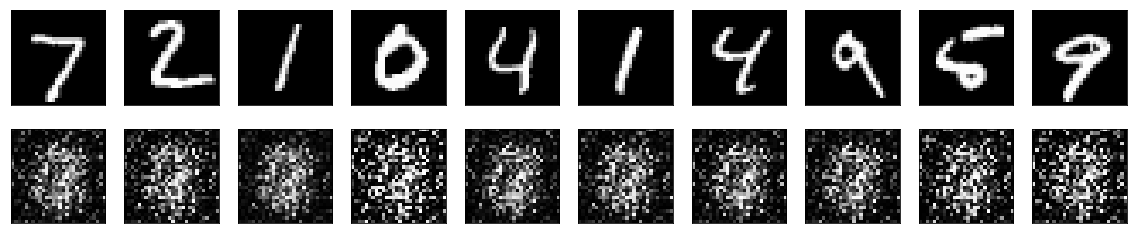

mean encoded activations fc1 sparse 1.66056e-06


In [10]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs_sparse = fc1AE_sparse.encoder_model().predict(x_val)
decoded_imgs_sparse = fc1AE_sparse.decoder_model().predict(encoded_imgs)

plot_decoded_results(x_val, decoded_imgs_sparse)

print("mean encoded activations fc1 sparse", encoded_imgs_sparse.mean())

### ConvAE model with 3 layers
> needs gpu to compute faster...

In [15]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

class ConvAE(object):
    def __init__(self):
        self.input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
        self.setup_training_model()

    def setup_training_model(self):

        x = Conv2D(16, (3, 3), activation='relu', padding='same')(self.input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        self.encoded = MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (4, 4, 8) i.e. 128-dimensional

        x = Conv2D(8, (3, 3), activation='relu', padding='same')(self.encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(16, (3, 3), activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        self.decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        self.autoencoder = Model(self.input_img, self.decoded)

    def encoder_model(self):
        # this model maps an input to its encoded representation
        return Model(self.input_img, self.encoded)

    def decoder_model(self):
        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(self.encoding_dim,))
        # retrieve the last layer of the autoencoder model
        decoder_layer = self.autoencoder.layers[-1]
        # create the decoder model
        return Model(encoded_input, decoder_layer(encoded_input))

    def train(self, x_train, x_val, nb_epochs=50):
        self.autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.autoencoder.fit(x_train, x_train,
                        epochs=nb_epochs,
                        batch_size=128,
                        shuffle=True,
                        validation_data=(x_val, x_val),
                        callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [ ]:
x_train, x_test = load_mnist_data_as_2d_images()
convAE = ConvAE()
convAE.train(x_train, x_test, nb_epochs=50)
print("Training ConvAE done")

Train on 60000 samples, validate on 10000 samples
Epoch 1/128
60000/60000 [==============================] - 79s 1ms/step - loss: 0.2779 - val_loss: 0.1981
Epoch 2/128
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1876 - val_loss: 0.1758
Epoch 3/128
60000/60000 [==============================] - 78s 1ms/step - loss: 0.1679 - val_loss: 0.1596
Epoch 4/128
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1566 - val_loss: 0.1550
Epoch 5/128
60000/60000 [==============================] - 75s 1ms/step - loss: 0.1483 - val_loss: 0.1460
Epoch 6/128
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1422 - val_loss: 0.1440
Epoch 7/128
60000/60000 [==============================] - 78s 1ms/step - loss: 0.1380 - val_loss: 0.1318
Epoch 8/128
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1348 - val_loss: 0.1311
Epoch 9/128
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1321 - val_loss: 0.1

In [ ]:
decoded_imgs_conv = autoencoder.predict(x_test)
plot_decoded_results(x_test, decoded_imgs_conv)

print("mean encoded activations convAE", decoded_imgs_conv.mean())

## Bayes VAE using 1 FC layer for encoder and decoder
> not learning a meaningfull distribution with $z = \mu + \sigma * N(0,1)$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.callbacks import TensorBoard

class BayesVAE(object):
    ''' Class to build a simple variational autoencoder with Keras.
     #Reference
     - Auto-Encoding Variational Bayes
       https://arxiv.org/abs/1312.6114
    '''

    def __init__(self,  original_dim, intermediate_dim, batch_size=32, epsilon_std=1.0, latent_dim=2):
        self.input_img = Input(shape=(original_dim,))
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epsilon_std = epsilon_std
        self.setup_dense_training_model()

    def setup_dense_training_model(self):
        x = self.input_img
        h = Dense(self.intermediate_dim, activation='relu')(x)
        self.z_mean = Dense(self.latent_dim)(h)
        # self.z_log_sigma = Dense(self.latent_dim)(h)
        self.z_log_var = Dense(self.latent_dim)(h)
        # sample latent variable z assuming normal distribution
        z = Lambda(self.normal_sampling, output_shape=(self.latent_dim,))([self.z_mean, self.z_log_var])
        self.decoder_h = Dense(self.intermediate_dim, activation='relu')
        self.decoder_mean = Dense(self.original_dim, activation='sigmoid')
        h_decoded = self.decoder_h(z)
        x_decoded_mean = self.decoder_mean(h_decoded)

        y = CustomVariationalLayer()([x, x_decoded_mean])
        self.vae = Model(x, y)

    def normal_sampling(self, args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(self.z_mean)[0], self.latent_dim), mean=0.,
                                  stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # def setup_conv_training_model(self):
        # x = Conv2D(16, (3, 3), activation='relu', padding='same')(self.input_img)
        # x = MaxPooling2D((2, 2), padding='same')(x)
        # x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        # x = MaxPooling2D((2, 2), padding='same')(x)
        # x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        # self.encoded = MaxPooling2D((2, 2), padding='same')(x)
        #
        # # at this point the representation is (4, 4, 8) i.e. 128-dimensional
        #
        # x = Conv2D(8, (3, 3), activation='relu', padding='same')(self.encoded)
        # x = UpSampling2D((2, 2))(x)
        # x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        # x = UpSampling2D((2, 2))(x)
        # x = Conv2D(16, (3, 3), activation='relu')(x)
        # x = UpSampling2D((2, 2))(x)
        # self.decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        #
        # self.autoencoder = Model(self.input_img, self.decoded)

    def encoder_model(self):
        # model mapping input to its encoded representation
        return Model(self.input_img, self.z_mean)

    def decoder_model(self):
        # decoder that samples from the learned distribution and decodes the mean back to input space
        decoder_input = Input(shape=(self.latent_dim,))
        _h_decoded = self.decoder_h(decoder_input)
        _x_decoded_mean = self.decoder_mean(_h_decoded)
        return Model(decoder_input, _x_decoded_mean)

    def train(self, x_train, x_test, nb_epochs=50):
        self.vae.compile(optimizer='rmsprop', loss=None)
        self.nb_epochs = nb_epochs
        self.vae.fit(x_train,
                shuffle=True,
                epochs=self.nb_epochs,
                batch_size=self.batch_size,
                validation_data=(x_test, None))

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, original_dim, z_mean, z_log_var, **kwargs):
        self.is_placeholder = True
        self.original_dim = original_dim
        self.z_mean = z_mean
        self.z_log_var = z_log_var
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = self.original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def update_latent_vars(self, update_values):
        self.z_mean = update_values[0]
        self.z_log_var = update_values[1]
    
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x


def scatterplot_latent_space(encoder, x_test, y_test, batch_size):
    """
    Display a 2D plot of the digit classes in the latent space learned with VAE
    :return: None
    """
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

def plot_manifold(generator):
    """
    Display a 2D scatterplot of the input manifold learned with VAE
    :param generator:
    :return:
    """
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [14]:
x_train, x_test, y_train, y_test = load_mnist_data()
bs = 100
fcVAE = BayesVAE(original_dim=784,intermediate_dim=256, batch_size=bs)
fcVAE.train(x_train, x_test, nb_epochs=50)
print("Training VAE done")

(60000, 784)
(10000, 784)


ValueError: Layer custom_variational_layer_5 was called with an input that isn't a symbolic tensor. Received type: <class 'int'>. Full input: [<tf.Tensor 'input_6:0' shape=(?, 784) dtype=float32>, <tf.Tensor 'dense_25/Sigmoid:0' shape=(?, 784) dtype=float32>, 784, <tf.Tensor 'dense_22/BiasAdd:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'dense_23/BiasAdd:0' shape=(?, 2) dtype=float32>]. All inputs to the layer should be tensors.

In [20]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

def vae_loss(x, x_decoded_mean):
    xent_loss = metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.2962 - val_loss: 0.2634
Epoch 2/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.2756 - val_loss: 0.2987
Epoch 3/50
60000/60000 [==============================] - 8s 142us/step - loss: 0.3469 - val_loss: 0.5120
Epoch 4/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.4947 - val_loss: 0.5078
Epoch 5/50
60000/60000 [==============================] - 9s 147us/step - loss: 0.6829 - val_loss: 0.6352
Epoch 6/50
60000/60000 [==============================] - 9s 145us/step - loss: 0.8543 - val_loss: 0.5495
Epoch 7/50
60000/60000 [==============================] - 9s 151us/step - loss: 1.0355 - val_loss: 0.9481
Epoch 8/50
60000/60000 [==============================] - 9s 156us/step - loss: 1.2697 - val_loss: 0.9905
Epoch 9/50
60000/60000 [==============================] - 9s 155us/step - loss: 1.5453 - val_loss: 2.

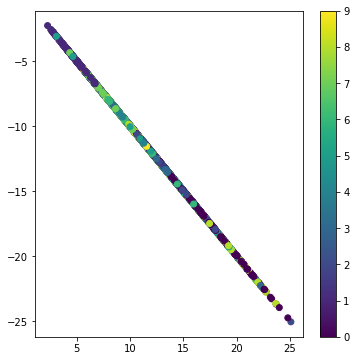

In [21]:
# build a model to project inputs on the latent space
# encoder = Model(x, z_mean)
# display a 2D plot of the digit classes in the latent space
scatterplot_latent_space(encoder, x_test, y_test, bs)

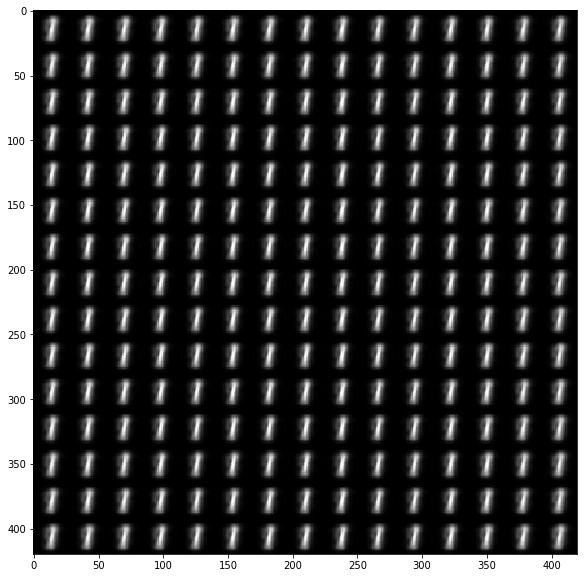

In [22]:
# build a digit generator that can sample from the learned distribution
# decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
# generator = Model(decoder_input, _x_decoded_mean)
# display a 2D manifold of the digits
plot_manifold(generator)

In [1]:
np.max(x_train)

NameError: name 'np' is not defined

In [ ]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()